Loading the dataset

In [1]:
import pandas as pd

data = pd.read_csv('data/new_product_info.csv')

Loading the saved random forest model

In [2]:
import joblib

# Load the saved model
final_model = joblib.load("data/model/random_forest_model.pkl")

classifier = final_model
print("Model loaded successfully!")

Model loaded successfully!


Detecting the Ingredients

In [37]:
import re

concern_chems = []
red_list = []
the_gens = []

# Function to normalize ingredient names
def normalize_ingredient(ingredient):
    ingredient = ingredient.lower()  # Convert to lowercase
    ingredient = re.sub(r'[-.,/]+', ' ', ingredient)  # Replace separators with space
    ingredient = re.sub(r'\s+', ' ', ingredient).strip()  # Remove extra spaces
    return ingredient

def split_and_normalize_ingredients(ingredients_list):
    all_ingredients = []
    for ingredients_str in ingredients_list:
        # Split by commas while preserving items with parentheses
        ingredients = re.split(r',\s*(?![^()]*\))', ingredients_str)
        # Normalize each ingredient
        normalized_ingredients = [ingredient for ingredient in ingredients]
        all_ingredients.extend(normalized_ingredients)
    return all_ingredients


# Input ingredients (list of ingredients to check)
input_ingredients = ["Aqua / Water / Eau, Niacinamide Propanediol, Peg/Ppg, Polybutylene Glycol-8/5/3 Glycerin, Glycerin, Methyl Gluceth-20, Peg-60 Hydrogenated Castor , Carbomer, Sodium Hyaluronate, Tocopherol, Hydroxyacetophenone, Citric Acid, Vitreoscilla Ferment, Caprylyl Glycol, Biosaccharide Gum-1, Maltodextrin, Butylene Glycol."]

with open("data/concern_chems.txt") as f:
    concern_chems = [line.strip() for line in f]

with open("data/red_list.txt") as f:
    red_list = [line.strip() for line in f]

with open("data/the_gens.txt") as f:
    the_gens = [line.strip() for line in f]


# Converting all lists into lower case
concern_chems1 = [normalize_ingredient(i) for i in concern_chems]
red_list1 = [normalize_ingredient(i) for i in red_list]
the_gens1 = [normalize_ingredient(i) for i in the_gens]
input_ingredients1 = [normalize_ingredient(ing) for ing in split_and_normalize_ingredients(input_ingredients)]


red_list_include = []
for i in input_ingredients1:
    for j in red_list1:
        if i in j:
            red_list_include.append(j)

the_gens_include = []
for i in input_ingredients1:
    for j in the_gens1:
        if i in j:
            if i not in red_list_include:
                the_gens_include.append(j)

concern_chems_include = []
for i in input_ingredients1:
    for j in concern_chems1:
        if i in j:
            if i not in red_list_include:
                if i not in the_gens_include:
                    concern_chems_include.append(j)

print("The Red List: ",red_list_include)
print("Allergens: ",the_gens_include)
print("Imerging chemicals of concern: ",concern_chems_include)

The Red List:  []
Allergens:  ['ethylhexylglycerin polysilicone 11', 'glycerin', 'acrylic acid carbomer']
Imerging chemicals of concern:  ['acrylic acid; carbomer', 'tocopherol']


Visualizing the detected ingredients

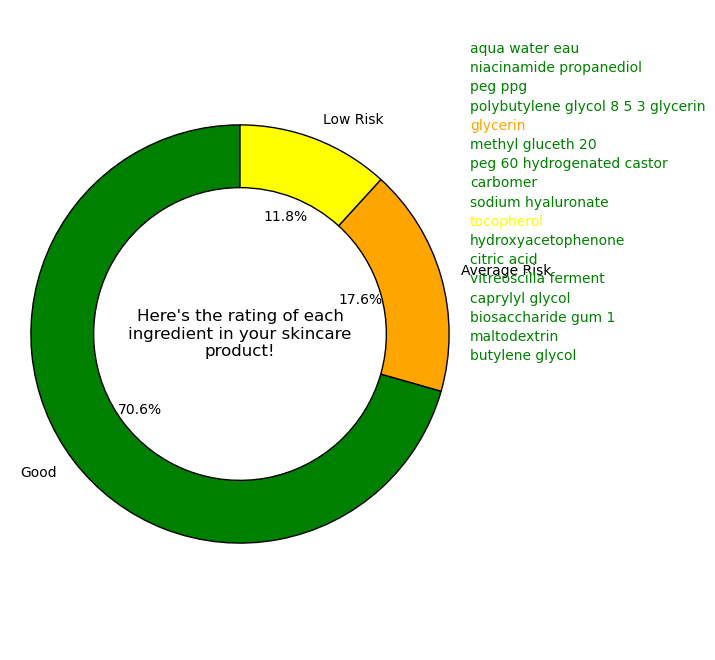

In [38]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# ... (your existing code for loading and processing ingredients) ...

# Calculate counts for visualization
high_risk_count = len(red_list_include)
average_risk_count = len(the_gens_include)
low_risk_count = len(concern_chems_include)
good_count = len(input_ingredients1) - high_risk_count - average_risk_count - low_risk_count

# Filter out zero-value categories
data = []
labels = []
colors = []

if good_count > 0:
    data.append(good_count)
    labels.append('Good')
    colors.append('green')
if high_risk_count > 0:
    data.append(high_risk_count)
    labels.append('High Risk')
    colors.append('red')
if average_risk_count > 0:
    data.append(average_risk_count)
    labels.append('Average Risk')
    colors.append('orange')
if low_risk_count > 0:
    data.append(low_risk_count)
    labels.append('Low Risk')
    colors.append('yellow')

# Visualization using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Donut chart parameters
wedgeprops = {'width': 0.3, 'edgecolor': 'black'}  # Adjust width for hole size
center_circle = Circle((0, 0), 0.4, color='white')  # Circle in the center
ax.add_artist(center_circle)

# Create the pie chart (with the "donut" hole)
wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%', startangle=90,
                                  colors=colors, labels=labels, wedgeprops=wedgeprops,
                                  textprops={'color': 'black'})

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Add title inside the donut hole
ax.text(0, 0, "Here's the rating of each\ningredient in your skincare\nproduct!", ha='center', va='center', fontsize=12, color='black')

# Add ingredient list (right side) if there are ingredients to display
if input_ingredients1:
    fig.subplots_adjust(right=0.7)  # Adjust right margin for ingredient list
    ax2 = fig.add_axes([0.7, 0.1, 0.25, 0.8])  # left, bottom, width, height
    ax2.axis('off')  # hide axis

    # Combine ingredients for display with correct colors
    ingredients_to_display = []
    for ing in input_ingredients1:
        if ing in red_list_include:
            ingredients_to_display.append((ing, 'red'))
        elif ing in the_gens_include:
            ingredients_to_display.append((ing, 'orange'))
        elif ing in concern_chems_include:
            ingredients_to_display.append((ing,'yellow' ))
        else:
            ingredients_to_display.append((ing, 'green'))

    # Display ingredients with color coding
    y_pos = 0.95
    for ing, color in ingredients_to_display:
        ax2.text(0, y_pos, ing, color=color, fontsize=10, va='top')
        y_pos -= 0.03  # Adjust spacing as needed

plt.show()

Using Sentence transformer to transform the ingredient list

In [39]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Preprocess the input ingredients
processed_input = " ".join([ingredient.lower().strip() for ingredient in input_ingredients])

# Compute the embedding for the input
input_embedding = model.encode(processed_input, convert_to_tensor=True)

Loading the trained word2vec model

In [11]:
from gensim.models import Word2Vec

# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("data/model/word2vec_model.model")

Predicting the category of the product

In [40]:
from gensim.utils import simple_preprocess
import numpy as np

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words match

# Figuring out the category using the pre-trained model
cat_pred_ingredients = " ".join(input_ingredients)

# Tokenize and generate embeddings
new_tokens = simple_preprocess(cat_pred_ingredients)
new_embedding = get_sentence_vector(word2vec_model, new_tokens).reshape(1, -1)

# Predict the category
predicted_category = classifier.predict(new_embedding)
print("Predicted Primary Category:", predicted_category[0])

Predicted Primary Category: Skincare


Utilizing the word embeddings

In [41]:
import json
import torch
from torch.nn.functional import cosine_similarity

def compute_similarity(input_emb, product_emb):
    return cosine_similarity(input_emb, product_emb, dim=0).item()

# Load the CSV files
ingredients_data = pd.read_csv("data/embeddings/ingredients_embedding.csv")
concern_chems_data = pd.read_csv("data/embeddings/concern_chems_embedding.csv")
red_list_data = pd.read_csv("data/embeddings/red_list_embedding.csv")
the_gens_data = pd.read_csv("data/embeddings/the_gens_embedding.csv")

# Re-assignng the original file to a variable
original_data = pd.read_csv('data/new_product_info.csv')

# Convert JSON string embeddings back to tensors
ingredients_data["ingredients_embedding"] = ingredients_data["ingredients_embedding"].apply(lambda x: torch.tensor(json.loads(x)))
concern_chems_data["concern_chems_embedding"] = concern_chems_data["concern_chems_embedding"].apply(lambda x: torch.tensor(json.loads(x)))
red_list_data["red_list_embedding"] = red_list_data["red_list_embedding"].apply(lambda x: torch.tensor(json.loads(x)))
the_gens_data["the_gens_embedding"] = the_gens_data["the_gens_embedding"].apply(lambda x: torch.tensor(json.loads(x)))

# Input primary category (assume we determine this beforehand)
input_primary_category = predicted_category[0] # Replace this with the actual category from the input

# Replace 'original_data' with the actual name of your DataFrame
filtered_data = original_data[original_data["primary_category"] == input_primary_category].copy()

# Calculate similarity scores only for filtered products
filtered_data["ingredient_similarity"] = ingredients_data["ingredients_embedding"].apply(
    lambda x: compute_similarity(input_embedding, x)
)
filtered_data["concern_chems_similarity"] = concern_chems_data["concern_chems_embedding"].apply(
    lambda x: compute_similarity(input_embedding, x)
)
filtered_data["red_list_similarity"] = red_list_data["red_list_embedding"].apply(
    lambda x: compute_similarity(input_embedding, x)
)
filtered_data["the_gens_similarity"] = the_gens_data["the_gens_embedding"].apply(
    lambda x: compute_similarity(input_embedding, x)
)

# Combine scores: prioritize high ingredient similarity and low harmful similarity
filtered_data["final_score"] = (
    filtered_data["ingredient_similarity"] - filtered_data["concern_chems_similarity"] - filtered_data["red_list_similarity"] - filtered_data["the_gens_similarity"]
)

Recommending the alternative

In [42]:
# Sort by the final score (descending)
recommended_products = filtered_data.sort_values(by="final_score", ascending=False)

# Get the top product
top_product = recommended_products.iloc[0]
print("Recommended Product:")
print(f"Name: {top_product['product_name']}")
print(f"Chemicals of concern: {top_product['concerning_chems_detected']}")
print(f"ASTHMAGENS, ALLERGENS, & IRRITANTS: {top_product['allergens_detected']}")
print(f"Highly Harmful ingredients: {top_product['red_list_chems_detected']}")
print(f"Similarity Score: {top_product['final_score']}")

Recommended Product:
Name: Powerful-Strength Vitamin C Serum
Chemicals of concern: []
ASTHMAGENS, ALLERGENS, & IRRITANTS: []
Highly Harmful ingredients: []
Similarity Score: 0.6238151639699936
